In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Define Process class
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority=5):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.priority = priority
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0
        self.remaining_time = burst_time

# FCFS Scheduling Function
def fcfs_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.burst_time + process.waiting_time
        current_time += process.burst_time
        total_waiting_time += process.waiting_time
        total_turnaround_time += process.turnaround_time
    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# SJF Scheduling Function
def sjf_scheduling(processes):
    processes.sort(key=lambda x: (x.arrival_time, x.burst_time))
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []
    while completed < n:
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.burst_time)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            current_process.waiting_time = current_time - current_process.arrival_time
            current_process.completion_time = current_time + current_process.burst_time
            current_process.turnaround_time = current_process.burst_time + current_process.waiting_time
            current_time += current_process.burst_time
            completed += 1
            total_waiting_time += current_process.waiting_time
            total_turnaround_time += current_process.turnaround_time
        else:
            current_time += 1
    return total_waiting_time / n, total_turnaround_time / n

# Round Robin Scheduling Function
def round_robin_scheduling(processes, time_quantum=4):
    current_time = 0
    queue = processes[:]
    for process in queue:
        process.remaining_time = process.burst_time
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)
    while queue:
        process = queue.pop(0)
        if process.remaining_time <= time_quantum:
            current_time += process.remaining_time
            process.waiting_time = current_time - process.arrival_time - process.burst_time
            process.turnaround_time = current_time - process.arrival_time
            total_waiting_time += process.waiting_time
            total_turnaround_time += process.turnaround_time
        else:
            current_time += time_quantum
            process.remaining_time -= time_quantum
            queue.append(process)
    return total_waiting_time / n, total_turnaround_time / n

# Preemptive Priority Scheduling Function
def priority_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    n = len(processes)
    total_waiting_time = 0
    total_turnaround_time = 0
    ready_queue = []

    while completed < n:
        # Add processes that have arrived to the ready queue
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)

        # Sort ready queue by priority, then by arrival time to pick the highest-priority process
        if ready_queue:
            ready_queue.sort(key=lambda x: (x.priority, x.arrival_time))
            current_process = ready_queue[0]

            # Process current task for one time unit
            current_time += 1
            current_process.remaining_time -= 1

            # If the process finishes, record times and remove it from the ready queue
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                total_waiting_time += current_process.waiting_time
                total_turnaround_time += current_process.turnaround_time
                completed += 1
                ready_queue.pop(0)  # Remove completed process from queue
        else:
            # If no processes are ready, advance time
            current_time += 1

    return total_waiting_time / n, total_turnaround_time / n


# Multilevel Queue Scheduling Function
def multilevel_queue_scheduling(processes, time_quantum=4):
    high_priority = [p for p in processes if p.priority <= 3]
    low_priority = [p for p in processes if p.priority > 3]
    total_waiting_time, total_turnaround_time = 0, 0
    n = len(processes)
    if high_priority:
        rr_wait, rr_turnaround = round_robin_scheduling(high_priority, time_quantum)
        total_waiting_time += rr_wait * len(high_priority)
        total_turnaround_time += rr_turnaround * len(high_priority)
    if low_priority:
        fcfs_wait, fcfs_turnaround = fcfs_scheduling(low_priority)
        total_waiting_time += fcfs_wait * len(low_priority)
        total_turnaround_time += fcfs_turnaround * len(low_priority)
    return total_waiting_time / n, total_turnaround_time / n

# Multilevel Feedback Queue Scheduling Function
def multilevel_feedback_queue_scheduling(processes, time_quantum=4, num_queues=3):
    queues = [[] for _ in range(num_queues)]
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)
    for process in processes:
        process.remaining_time = process.burst_time
        queues[0].append(process)
    for i in range(num_queues):
        while queues[i]:
            process = queues[i].pop(0)
            quantum = time_quantum * (2 ** i)
            if process.remaining_time > quantum:
                current_time += quantum
                process.remaining_time -= quantum
                if i < num_queues - 1:
                    queues[i + 1].append(process)
                else:
                    queues[i].append(process)
            else:
                current_time += process.remaining_time
                process.waiting_time = current_time - process.arrival_time - process.burst_time
                process.turnaround_time = current_time - process.arrival_time
                total_waiting_time += process.waiting_time
                total_turnaround_time += process.turnaround_time
    return total_waiting_time / n, total_turnaround_time / n

# Update process generation to include random priority
def generate_random_processes(num_processes):
    return [Process(pid=i+1, arrival_time=random.randint(0, 10), burst_time=random.randint(1, 10), priority=random.randint(1, 5)) for i in range(num_processes)]

# Run simulations
def run_large_scale_simulation(num_simulations=1000, num_processes=10, time_quantum=4):
    fcfs_waiting_times = np.zeros(num_simulations)
    fcfs_turnaround_times = np.zeros(num_simulations)
    sjf_waiting_times = np.zeros(num_simulations)
    sjf_turnaround_times = np.zeros(num_simulations)
    rr_waiting_times = np.zeros(num_simulations)
    rr_turnaround_times = np.zeros(num_simulations)
    priority_waiting_times = np.zeros(num_simulations)
    priority_turnaround_times = np.zeros(num_simulations)
    mlq_waiting_times = np.zeros(num_simulations)
    mlq_turnaround_times = np.zeros(num_simulations)
    mlfq_waiting_times = np.zeros(num_simulations)
    mlfq_turnaround_times = np.zeros(num_simulations)

    for i in range(num_simulations):
        processes = generate_random_processes(num_processes)

        fcfs_avg_waiting, fcfs_avg_turnaround = fcfs_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes])
        fcfs_waiting_times[i] = fcfs_avg_waiting
        fcfs_turnaround_times[i] = fcfs_avg_turnaround

        sjf_avg_waiting, sjf_avg_turnaround = sjf_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes])
        sjf_waiting_times[i] = sjf_avg_waiting
        sjf_turnaround_times[i] = sjf_avg_turnaround

        rr_avg_waiting, rr_avg_turnaround = round_robin_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes], time_quantum)
        rr_waiting_times[i] = rr_avg_waiting
        rr_turnaround_times[i] = rr_avg_turnaround

        priority_avg_waiting, priority_avg_turnaround = priority_scheduling([Process(p.pid, p.arrival_time, p.burst_time, random.randint(1, 5)) for p in processes])
        priority_waiting_times[i] = priority_avg_waiting
        priority_turnaround_times[i] = priority_avg_turnaround

        mlq_avg_waiting, mlq_avg_turnaround = multilevel_queue_scheduling([Process(p.pid, p.arrival_time, p.burst_time, random.randint(1, 5)) for p in processes], time_quantum)
        mlq_waiting_times[i] = mlq_avg_waiting
        mlq_turnaround_times[i] = mlq_avg_turnaround

        mlfq_avg_waiting, mlfq_avg_turnaround = multilevel_feedback_queue_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes], time_quantum)
        mlfq_waiting_times[i] = mlfq_avg_waiting
        mlfq_turnaround_times[i] = mlfq_avg_turnaround

    return (fcfs_waiting_times, fcfs_turnaround_times, sjf_waiting_times, sjf_turnaround_times,
            rr_waiting_times, rr_turnaround_times, priority_waiting_times, priority_turnaround_times,
            mlq_waiting_times, mlq_turnaround_times, mlfq_waiting_times, mlfq_turnaround_times)

def visualize_large_scale_results_with_solid_averages(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                                                      rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
                                                      mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround):

    # Color palette
    colors = {
        "FCFS": "#1f77b4",       # Blue
        "SJF": "#ff7f0e",        # Orange
        "Round Robin": "#2ca02c", # Green
        "Priority": "#d62728",   # Red
        "MLQ": "#9467bd",        # Purple
        "MLFQ": "#8c564b"        # Brownish
    }

    # Colors for bar chart
    bar_colors = {"Waiting Time": "#1f77b4", "Turnaround Time": "#ff7f0e"}

    # Calculate overall averages
    overall_averages = {
        "FCFS": [np.mean(fcfs_waiting), np.mean(fcfs_turnaround)],
        "SJF": [np.mean(sjf_waiting), np.mean(sjf_turnaround)],
        "Round Robin": [np.mean(rr_waiting), np.mean(rr_turnaround)],
        "Priority": [np.mean(priority_waiting), np.mean(priority_turnaround)],
        "MLQ": [np.mean(mlq_waiting), np.mean(mlq_turnaround)],
        "MLFQ": [np.mean(mlfq_waiting), np.mean(mlfq_turnaround)]
    }

    # Line chart for Waiting Time
    plt.figure(figsize=(18, 24))
    plt.subplot(3, 1, 1)
    plt.plot(fcfs_waiting, label="FCFS", color=colors["FCFS"], alpha=0.4)
    plt.axhline(y=overall_averages["FCFS"][0], color=colors["FCFS"], linestyle="-")
    plt.text(0, overall_averages["FCFS"][0], f"{overall_averages['FCFS'][0]:.2f} ms",
             color=colors["FCFS"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(sjf_waiting, label="SJF", color=colors["SJF"], alpha=0.4)
    plt.axhline(y=overall_averages["SJF"][0], color=colors["SJF"], linestyle="-")
    plt.text(0, overall_averages["SJF"][0], f"{overall_averages['SJF'][0]:.2f} ms",
             color=colors["SJF"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(rr_waiting, label="Round Robin", color=colors["Round Robin"], alpha=0.4)
    plt.axhline(y=overall_averages["Round Robin"][0], color=colors["Round Robin"], linestyle="-")
    # Raise the Round Robin label slightly higher to avoid overlap
    plt.text(0, overall_averages["Round Robin"][0] + 0.5, f"{overall_averages['Round Robin'][0]:.2f} ms",
             color=colors["Round Robin"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(priority_waiting, label="Priority", color=colors["Priority"], alpha=0.4)
    plt.axhline(y=overall_averages["Priority"][0], color=colors["Priority"], linestyle="-")
    plt.text(0, overall_averages["Priority"][0], f"{overall_averages['Priority'][0]:.2f} ms",
             color=colors["Priority"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(mlq_waiting, label="MLQ", color=colors["MLQ"], alpha=0.4)
    plt.axhline(y=overall_averages["MLQ"][0], color=colors["MLQ"], linestyle="-")
    plt.text(0, overall_averages["MLQ"][0], f"{overall_averages['MLQ'][0]:.2f} ms",
             color=colors["MLQ"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(mlfq_waiting, label="MLFQ", color=colors["MLFQ"], alpha=0.4)
    plt.axhline(y=overall_averages["MLFQ"][0], color=colors["MLFQ"], linestyle="-")
    plt.text(0, overall_averages["MLFQ"][0], f"{overall_averages['MLFQ'][0]:.2f} ms",
             color=colors["MLFQ"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.xlabel("Simulation #")
    plt.ylabel("Average Waiting Time (ms)")
    plt.title("Average Waiting Time per Simulation")
    plt.legend()

    # Line chart for Turnaround Time
    plt.subplot(3, 1, 2)
    plt.plot(fcfs_turnaround, label="FCFS", color=colors["FCFS"], alpha=0.4)
    plt.axhline(y=overall_averages["FCFS"][1], color=colors["FCFS"], linestyle="-")
    plt.text(0, overall_averages["FCFS"][1], f"{overall_averages['FCFS'][1]:.2f} ms",
             color=colors["FCFS"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(sjf_turnaround, label="SJF", color=colors["SJF"], alpha=0.4)
    plt.axhline(y=overall_averages["SJF"][1], color=colors["SJF"], linestyle="-")
    plt.text(0, overall_averages["SJF"][1], f"{overall_averages['SJF'][1]:.2f} ms",
             color=colors["SJF"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(rr_turnaround, label="Round Robin", color=colors["Round Robin"], alpha=0.4)
    plt.axhline(y=overall_averages["Round Robin"][1], color=colors["Round Robin"], linestyle="-")
    # Raise the Round Robin label slightly higher to avoid overlap
    plt.text(0, overall_averages["Round Robin"][1] + 0.5, f"{overall_averages['Round Robin'][1]:.2f} ms",
             color=colors["Round Robin"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(priority_turnaround, label="Priority", color=colors["Priority"], alpha=0.4)
    plt.axhline(y=overall_averages["Priority"][1], color=colors["Priority"], linestyle="-")
    plt.text(0, overall_averages["Priority"][1], f"{overall_averages['Priority'][1]:.2f} ms",
             color=colors["Priority"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(mlq_turnaround, label="MLQ", color=colors["MLQ"], alpha=0.4)
    plt.axhline(y=overall_averages["MLQ"][1], color=colors["MLQ"], linestyle="-")
    plt.text(0, overall_averages["MLQ"][1], f"{overall_averages['MLQ'][1]:.2f} ms",
             color=colors["MLQ"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.plot(mlfq_turnaround, label="MLFQ", color=colors["MLFQ"], alpha=0.4)
    plt.axhline(y=overall_averages["MLFQ"][1], color=colors["MLFQ"], linestyle="-")
    plt.text(0, overall_averages["MLFQ"][1], f"{overall_averages['MLFQ'][1]:.2f} ms",
             color=colors["MLFQ"], ha="right", va="center", fontsize=9,
             bbox=dict(facecolor="white", edgecolor="black"))

    plt.xlabel("Simulation #")
    plt.ylabel("Average Turnaround Time (ms)")
    plt.title("Average Turnaround Time per Simulation")
    plt.legend()
    plt.subplot(3, 1, 3)
    labels = list(overall_averages.keys())
    waiting_times = [overall_averages[alg][0] for alg in labels]
    turnaround_times = [overall_averages[alg][1] for alg in labels]

    bar_width = 0.35
    index = np.arange(len(labels))

    # Plotting the bars for waiting times and turnaround times
    plt.bar(index, waiting_times, bar_width, color=bar_colors["Waiting Time"], label="Average Waiting Time")
    plt.bar(index + bar_width, turnaround_times, bar_width, color=bar_colors["Turnaround Time"], label="Average Turnaround Time")

    # Adding labels and title
    plt.xlabel("Scheduling Algorithms")
    plt.ylabel("Average Time (ms)")
    plt.title("Overall Average Waiting and Turnaround Times")
    plt.xticks(index + bar_width / 2, labels)

    # Adding data labels above each bar
    for i, v in enumerate(waiting_times):
        plt.text(i, v + 0.1, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(turnaround_times):
        plt.text(i + bar_width, v + 0.1, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)

    # Adding legend and layout adjustments
    plt.legend()
    plt.tight_layout()
    plt.show()

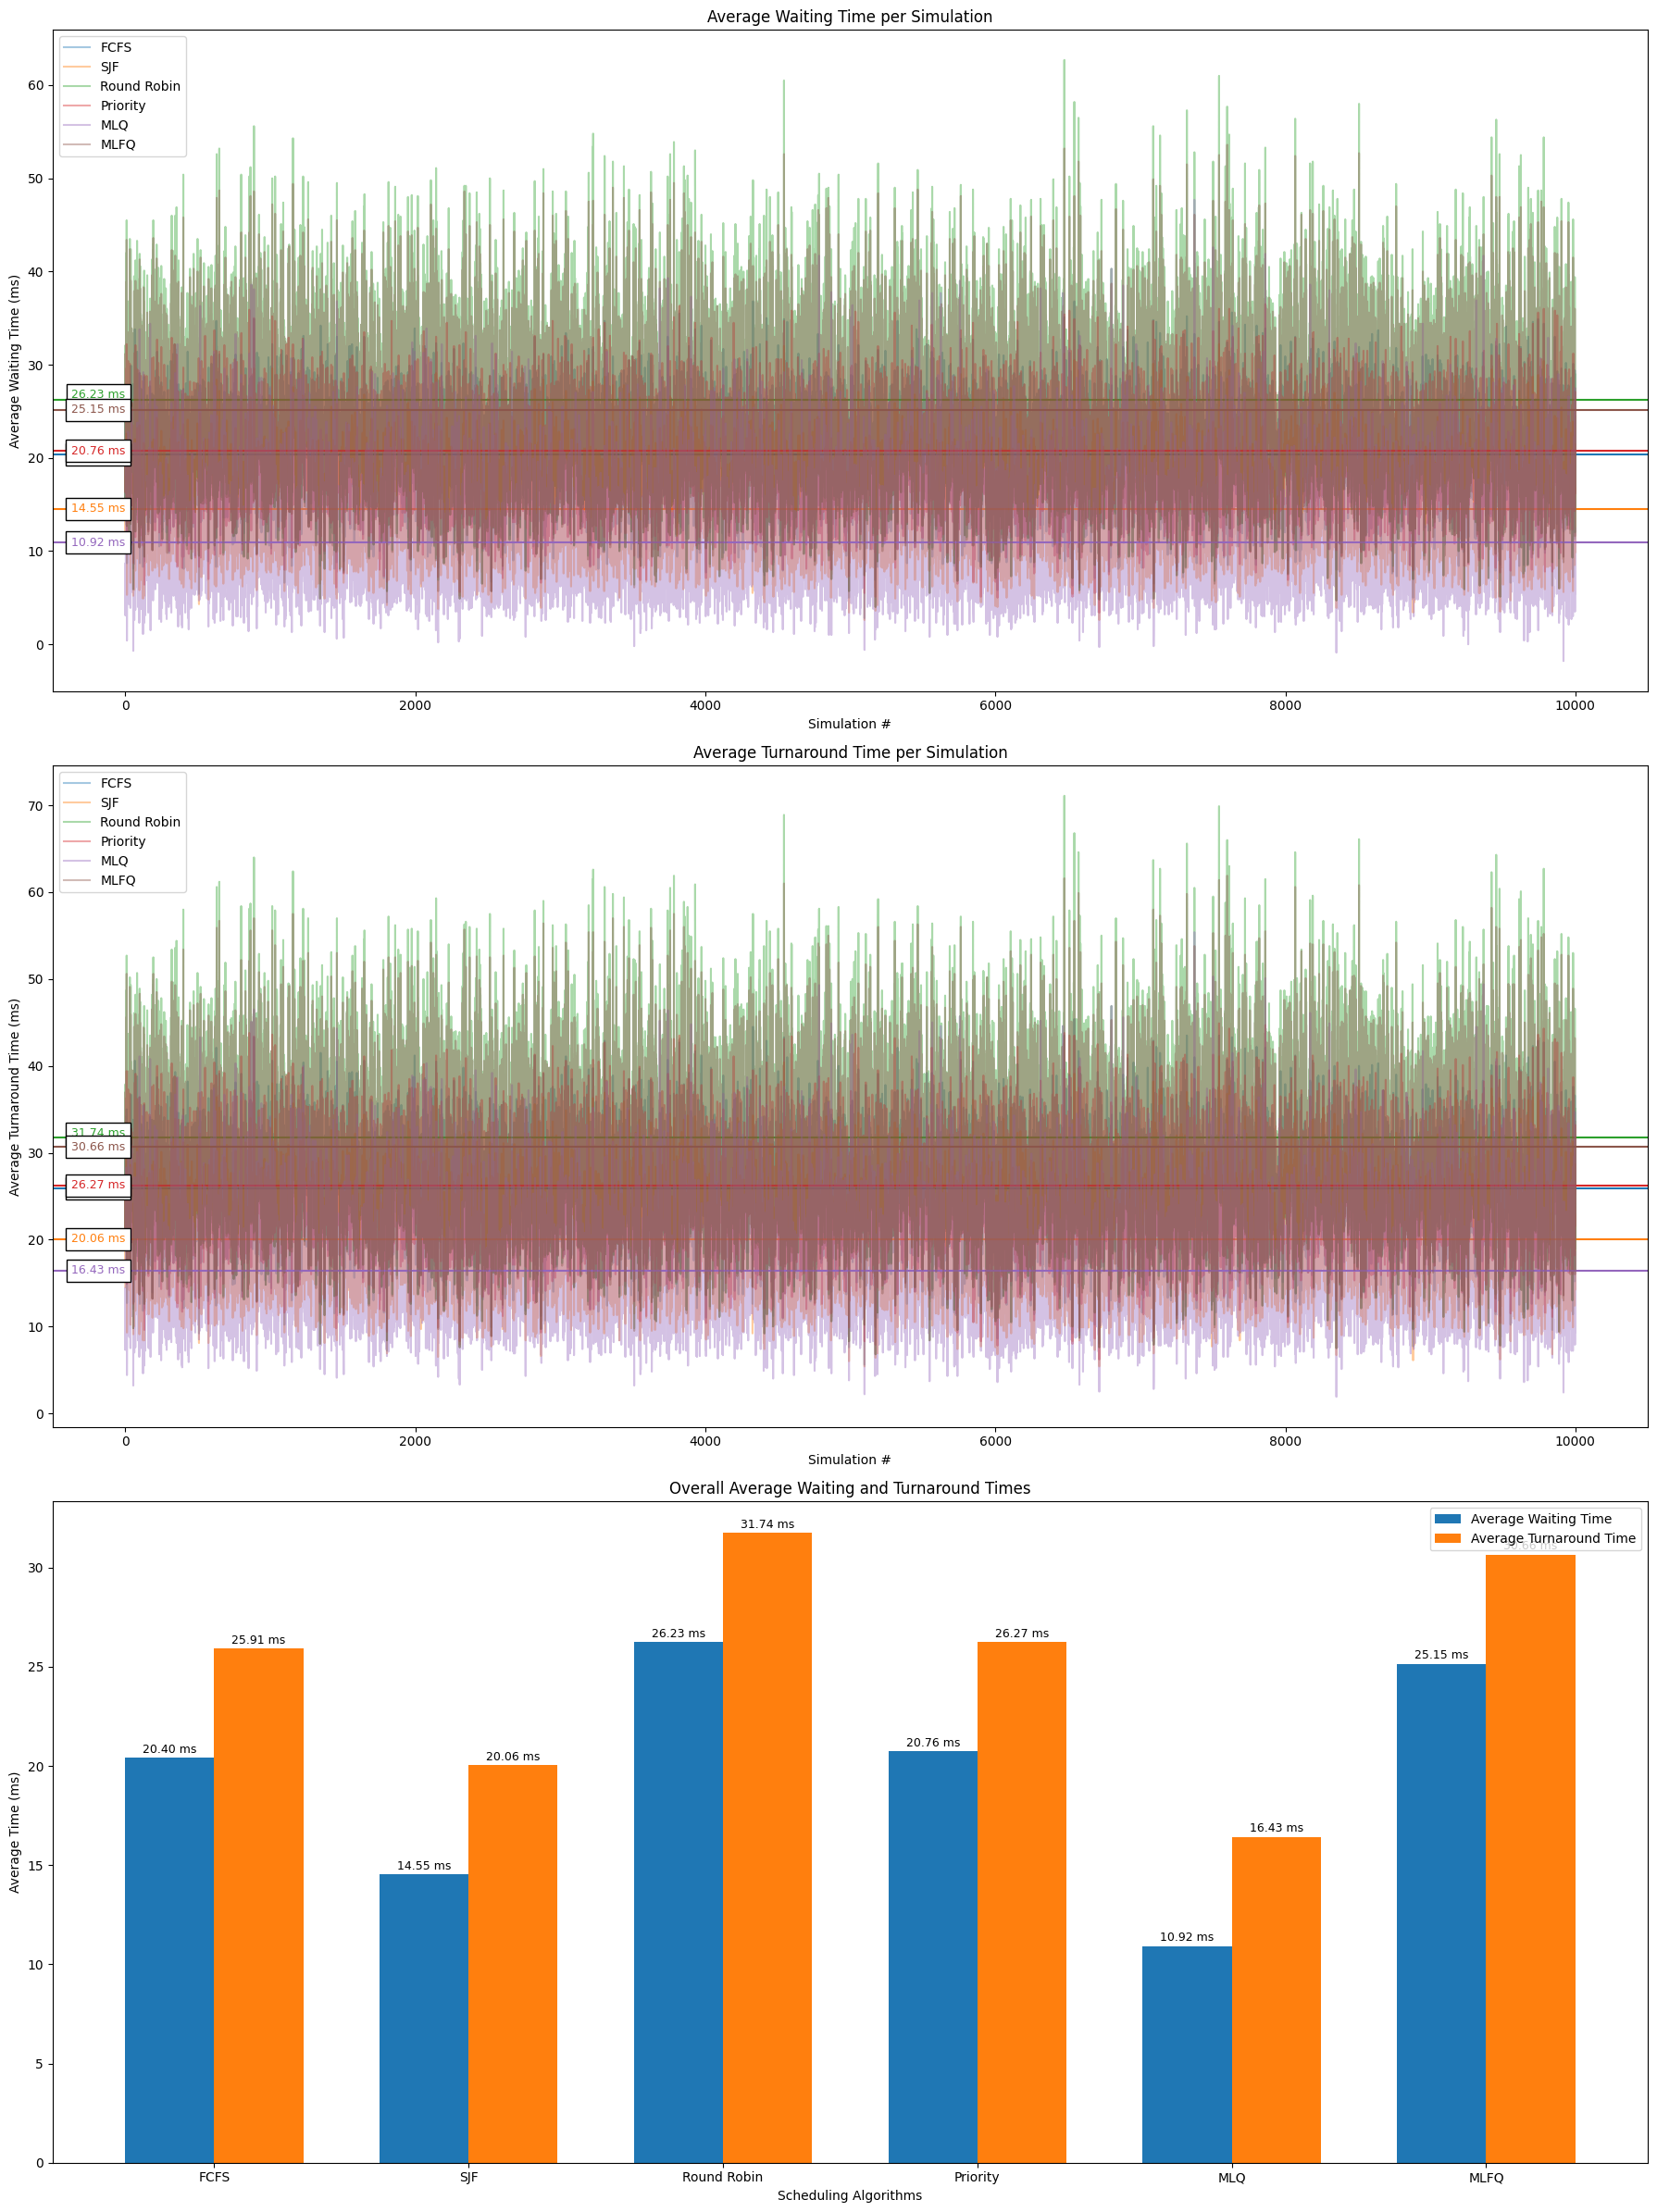

In [6]:
# Run simulation and visualize results: 10 Processes
if __name__ == "__main__":
    # Run the large scale simulation
    results = run_large_scale_simulation(num_simulations=10000, num_processes=10, time_quantum=4)

    # Unpack the results
    (fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
     rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
     mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround) = results

    # Visualize the results
    visualize_large_scale_results_with_solid_averages(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                                                      rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
                                                      mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround)

In [ ]:
# Run simulation and visualize results: 100 Processes
if __name__ == "__main__":
    # Run the large scale simulation
    results = run_large_scale_simulation(num_simulations=10000, num_processes=100, time_quantum=4)

    # Unpack the results
    (fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
     rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
     mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround) = results

    # Visualize the results
    visualize_large_scale_results_with_solid_averages(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                                                      rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
                                                      mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround)

In [ ]:
# Run simulation and visualize results: 300 Process
if __name__ == "__main__":
    # Run the large scale simulation
    results = run_large_scale_simulation(num_simulations=10000, num_processes=300, time_quantum=4)

    # Unpack the results
    (fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
     rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
     mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround) = results

    # Visualize the results
    visualize_large_scale_results_with_solid_averages(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                                                      rr_waiting, rr_turnaround, priority_waiting, priority_turnaround